In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.integrate import solve_ivp
from sklearn.model_selection import train_test_split
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from matplotlib.colors import to_rgb, to_rgba
import matplotlib as mpl


/var/folders/jy/2rzmkmcj07n0mybtd99wpfjm0000gn/T/ipykernel_88829/832743698.py:154: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "orientation" which is no longer supported as of 3.3 and will become an error two minor releases later
  ani.save('stochastic_resonance.gif', fps=25)
/var/folders/jy/2rzmkmcj07n0mybtd99wpfjm0000gn/T/ipykernel_88829/832743698.py:154: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "facecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  ani.save('stochastic_resonance.gif', fps=25)
/var/folders/jy/2rzmkmcj07n0mybtd99wpfjm0000gn/T/ipykernel_88829/832743698.py:154: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "edgecolor" which is no longer supported as of 3.3 and will become an error two minor releases later
  ani.save('stochastic_resonance.gif', fps=25)
/var/folders/jy/2rzmkmcj07n0mybtd99wpfjm0000gn/T/ipykernel_88829/832743698.py:154: Matplo

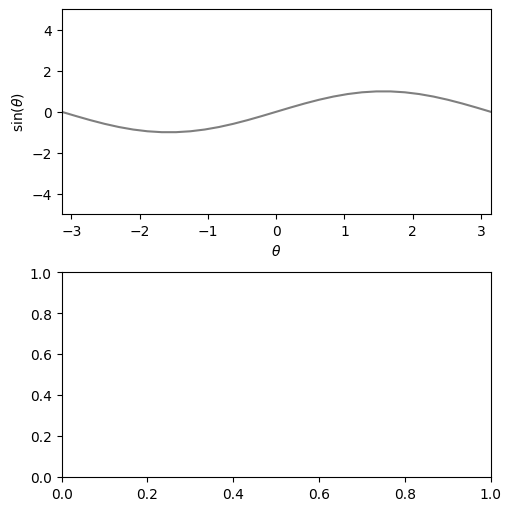

In [30]:
Npts = 31
thetas = np.linspace(-np.pi, np.pi, Npts)
X_all = np.array([np.cos(thetas), np.sin(thetas)]).T

Y_all = np.sin(thetas)
clip = .3
# Y = np.clip(Y, -clip, +clip)
train_size = 5

equi = True
pi = np.pi
thetas_tr = np.array([-pi, 0, pi])
thetas_tr, thetas_ts = thetas_tr, thetas[~np.in1d(thetas, thetas_tr)]

i_tr = np.arange(len(thetas))[np.in1d(thetas, thetas_tr)]
i_ts = np.arange(len(thetas))[~np.in1d(thetas, thetas_tr)]

X_tr, X_ts = X_all[i_tr], X_all[i_ts]
Y_tr, Y_ts = Y_all[i_tr], Y_all[i_ts]


isort = np.argsort(thetas)
isort_tr = np.argsort(thetas_tr)
isort_ts = np.argsort(thetas_ts)

thetas = thetas[isort]
X_all = X_all[isort]
Y_all = Y_all[isort]

X_tr = X_tr[isort_tr]
Y_tr = Y_tr[isort_tr]
thetas_tr = thetas_tr[isort_tr]
i_tr = i_tr[isort_tr]

X_ts = X_ts[isort_ts]
Y_ts = Y_ts[isort_ts]
thetas_ts = thetas_ts[isort_ts]
i_ts = i_ts[isort_ts]

# kxX = k_inf_X(X, X_tr)
# kXX = k_inf_X(X_tr, X_tr)
# Y_pred = kxX @ np.linalg.inv(kXX) @ Y_tr


# put this into a Boltmann ensemble
# E = lambda y: Y.T@np.linalg.inv(K_XX_all)@Y/2

# simulate a trajectory
# this should relax quickly to a finite corr-length GP?!
# sample this from a GP, otherwise white noise might be somehow frustrating
# Y_init = np.random.normal(0, 0.1, size=len(Y))

# get the mode-dependent kernel

def F_R(K, X, resc=1.):
    # divide by lenX to have scale-invariant ODE
    F = -np.einsum('kl,...l', K, X) / len(X)
    # F/=resc
    # F = F/np.max(np.abs(F))

    return F

def run_sim(Y_init, ts, k_XX_all, ):
    # the kernel is the covariance of the normal distribution, hence, we shouldn't have an inverse here. 
    # NOTE: How does this relate to MSE? For this, we assume that the oscillator is 
    # Y_init = np.random.multivariate_normal([0]*len(X_all), k_XX_all)
    Y_init = Y_all
    # Y_init = Y
    # Y_init[i_tr] = Y[i_tr]

    v_init = np.random.normal(0, 0.0, size=len(Y_all))*0.
    z_init = np.concatenate([Y_init, v_init], axis=-1)
    
    N_T = len(ts)
    N_th = len(thetas)
    # assert (np.linalg.eigvals(c_tot) >= 0.).all()

    # fig, (ax1, ax2) = plt.subplots(2,1)
    # ax1.plot(thetas, xi[0,:], label=f"lcorr={l_th}")
    # ax2.plot(ts, xi[:,0], label=f"lcorr={l_t}")
    # ax1.legend()
    # ax2.legend()
    # plt.savefig("corr.png")

    # xi = np.array([np.random.multivariate_normal(np.zeros( c_tau.shape[0]),  c_tot) for i in range(Npts)]).T
    # xi = np.concatenate([xi, xi], axis=-1)

    xi = np.random.normal(0, 0.01, size=(len(ts), len(Y_all)))*0
    M = np.ones(len(Y_all))
    M[i_tr] = 100.

    def f(t, z):
        
        x = z[...,:Npts]
        v = z[...,Npts:]

        # the force can be formulated in terms of an MSE, see manuscript_2023.lyx notes
        admittance_0_modes = 0.*.1
        
        # F = np.sin(x)*np.sum([np.cos(a*t) for a in np.geomspace(.01, 10, 10)], axis=0)
        # F = np.sin(x)*np.random.normal(0, .01, size=len(x))

        # wave drive
        F = 0.01*np.sin(x/2)*np.cos(t)

        F = F + F_R(np.linalg.inv(k_XX_all), x)

        # # some dissipation to bound the energy present in the system
        gamma=.001
        F = F - gamma*v

        # # external drive
        F = F + xi[np.argmin((t-ts)**2)]*0.

        # clamp the training points
        # F[...,i_tr] = 0.
        # v[...,i_tr] = 0.


        return np.concatenate([v,F/M], axis=-1)

    sol = solve_ivp(f, [ts.min(), ts.max()], z_init, t_eval=ts, rtol=1e-2, atol=1e-2)
    ts_sol = sol.t
    sol = sol.y.T
    sol_x = sol[:,:Npts]
    sol_v = sol[:,Npts:]
    Y = sol_x

    return Y, ts_sol, xi

lmbd_ = 1 / len(thetas) * 10
rel_slack = 5*1e-5
k_XX_all = lmbd_*np.cos(thetas[:,None] - thetas[None,:]) + rel_slack*lmbd_*np.eye(len(thetas))
ts = np.linspace(0, 100, 100)
Y, ts, xi = run_sim(Y_all, ts, k_XX_all, )

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(5,5), constrained_layout=True)

l, = ax1.plot(thetas, Y[0,:], 'k', alpha=0.5)

def update(ti):
    l.set_data(thetas, Y[ti,:])

ax1.set_xlim(-np.pi, np.pi)
ax1.set_ylim(-5, 5)
ax1.set_xlabel(r"$\theta$")
ax1.set_ylabel(r"$\sin(\theta)$")

# create the animation object
tau = 1. # in seconds
interval_ms = 1000*tau/len(ts)*np.diff(ts)[0]
ani = animation.FuncAnimation(fig, update, frames=len(ts), interval=interval_ms, repeat=True)
# write out a gif
ani.save('stochastic_resonance.gif', fps=25)

In [ ]:
# Create a time vector
t = np.linspace(0, 1, 1000, False)  # 1 second

# Create a sinusoidal signal
freq = 5  # frequency of the signal
sinusoid = np.sin(2*np.pi*freq*t)

# Create white noise
noise = np.random.normal(0, 0.5, 1000)

# Add the sinusoid and the noise
signal = sinusoid + noise

# Plot the original sinusoid, the noise, and the resulting signal
plt.figure(figsize=(14, 7))
plt.subplot(3,1,1)
plt.plot(t, sinusoid)
plt.title('Original Sinusoid')
plt.subplot(3,1,2)
plt.plot(t, noise)
plt.title('White Noise')
plt.subplot(3,1,3)
plt.plot(t, signal)
plt.title('Resulting Signal')
plt.tight_layout()
plt.show()


In [ ]:
# Compute the FFT
fft_sinusoid = fft(sinusoid)
fft_noise = fft(noise)
fft_signal = fft(signal)

# Compute the power spectral density
psd_sinusoid = np.abs(fft_sinusoid) ** 2
psd_noise = np.abs(fft_noise) ** 2
psd_signal = np.abs(fft_signal) ** 2

# Compute the frequencies corresponding to the values of the PSD
freqs = np.fft.fftfreq(len(sinusoid), t[1]-t[0])

# Plot the power spectral density
plt.figure(figsize=(14, 7))
plt.subplot(3,1,1)
plt.plot(freqs[:len(freqs)//2], psd_sinusoid[:len(psd_sinusoid)//2])
plt.title('PSD of Original Sinusoid')
plt.subplot(3,1,2)
plt.plot(freqs[:len(freqs)//2], psd_noise[:len(psd_noise)//2])
plt.title('PSD of White Noise')
plt.subplot(3,1,3)
plt.plot(freqs[:len(freqs)//2], psd_signal[:len(psd_signal)//2])
plt.title('PSD of Resulting Signal')
plt.tight_layout()
plt.show()
